# Task 1: Response to Data analysis and feature engineering
使用pandas导入训练数据集，并分析特征和标签的分布情况。

In [147]:
import platform
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
# 导入缺失的库
from sklearn.decomposition import FastICA
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# 设置随机种子和中文显示
np.random.seed(42)
# 设置中文显示
system = platform.system()

if system == 'Darwin':  # Mac系统
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
elif system == 'Windows':  # Windows系统
    plt.rcParams['font.sans-serif'] = ['SimHei']  # 黑体
elif system == 'Linux':  # Linux系统
    # Linux系统可能需要安装中文字体，例如 Noto Sans CJK SC
    plt.rcParams['font.sans-serif'] = ['Noto Sans CJK SC']
else:
    # 默认字体（如果系统未识别）
    plt.rcParams['font.sans-serif'] = ['SimHei']

# 读取数据
df = pd.read_csv("./student_data.csv")

# 初始化模型存储结构
# 在代码开头初始化完整的字典结构
grade_models = {
    'pca_model': {},
    'bayes_models': {},
    'random_forest_models': {}
}

# 系别映射（如果需要）
mapping = {1: 'A', 2: 'B', 3: 'C', 4: 'D'}
if df['Programme'].dtype == 'int64' or df['Programme'].iloc[0] in [1, 2, 3, 4]:
    df['Programme'] = df['Programme'].map(mapping)


导入数据后，查看数据集的基本信息。处理数据缺失
## 特征转换
应用三种不同的数据转换方法：标准化缩放、PCA降维和独立成分分析(ICA)

In [161]:
# 第二个代码单元格 - 数据加载和探索
# 读取数据
df = pd.read_csv("./student_data.csv")

# 系别映射（如果需要）
mapping = {1: 'A', 2: 'B', 3: 'C', 4: 'D'}
if df['Programme'].dtype == 'int64' or df['Programme'].iloc[0] in [1, 2, 3, 4]:
    df['Programme'] = df['Programme'].map(mapping)

# 检查数据集
print(f"数据集形状: {df.shape}")
print("\n数据集前5行:")
display(df.head())

print("\n数据集信息:")
display(df.info())

print("\n数据集统计描述:")
display(df.describe())

# 检查缺失值
print(f"\n缺失值情况:")
display(df.isnull().sum())

# 选择数值特征并排除索引列
# 假设df.index可能被转换为数据列，我们需要排除它
columns_to_use = df.select_dtypes(include=['float64', 'int64']).columns
# 如果索引已转换为列并带有特定名称（例如'index'），则排除它
if 'index' in columns_to_use:
    columns_to_use = columns_to_use.drop('index')
X = df[columns_to_use]

print(f"\n特征集形状: {X.shape}")
# 创建三种不同的特征组合
# 准备数据
# 假设我们的数据集包含：学生ID、性别、项目、年级、总分和5个考试问题分数

# 排除索引列
numeric_df = df.select_dtypes(include=['float64', 'int64'])
if 'index' in numeric_df.columns:
    numeric_df = numeric_df.drop('index', axis=1)

# 创建三种不同的特征集
feature_sets = {}

# 特征集1: 考试分数特征 (Q1-Q5)
# 选择问题相关列
if all(f'Q{i}' in numeric_df.columns for i in range(3, 7)):
    exam_features = numeric_df[[f'Q{i}' for i in range(3, 7)]]
    feature_sets['考试分数'] = exam_features.values
elif 'Q1' in numeric_df.columns:  # 灵活处理列名
    # 尝试查找包含'Q'的列
    exam_cols = [col for col in numeric_df.columns if 'Q' in col]
    feature_sets['考试分数'] = numeric_df[exam_cols].values
else:
    # 如果没有明确的问题列，使用部分数值特征
    feature_sets['考试分数'] = numeric_df.iloc[:, -5:].values  # 假设最后5列是成绩

# 特征集2: 学生基本信息 (性别、项目、年级、总分)
# 查找这些列或相似列
basic_cols = []
# 这里假设我们知道这些列的名称或可以通过模式匹配找到它们 'programme', 'Programme'是项目列
for col_pattern in ['性别', 'Gender', 'sex',  '项目', 'Total', '总分','Q1','Q2','Q3','Q4','Q5']:
    matching_cols = [col for col in numeric_df.columns if col_pattern.lower() in col.lower()]
    basic_cols.extend(matching_cols)

if basic_cols:
    feature_sets['去除年级'] = numeric_df[basic_cols].values
else:
    # 如果没有找到匹配列，使用前几列
    feature_sets['去除年级'] = numeric_df.iloc[:, 1,2].values  # 假设前几列是学生信息

# 特征集3: 所有特征的组合，但排除programme
programme_cols = [col for col in numeric_df.columns if 'programme' in col.lower() or 'program' in col.lower()]
if programme_cols:
    feature_sets['全部特征'] = numeric_df.drop(columns=programme_cols).values
    print(f"从全部特征中排除了以下列: {programme_cols}")
else:
    feature_sets['全部特征'] = numeric_df.values
    print("未找到programme相关列，使用了所有数值特征")

print("创建的特征集:")
for name, features in feature_sets.items():
    print(f"- {name}: 形状 {features.shape}")


# 检查特征集
for name, data in feature_sets.items():
    print(f"\n特征集: {name}")
    print(f"数据集形状: {data.shape}")
    print("\n数据集前5行:")
    # 将 NumPy 数组的前几行转为 DataFrame 以便更好地显示
    pd.DataFrame(data[:5]).to_numpy()
    # 或者直接打印数组的前几行
    print(data[:5])

# 对每个特征集应用标准化
for name in feature_sets:
    scaler = StandardScaler()
    feature_sets[name] = scaler.fit_transform(feature_sets[name])

数据集形状: (466, 10)

数据集前5行:


,Index,Gender,Grade,Q1,Q2,Q3,Q4,Q5,Programme,Total
0,1,1,3,8,4,2,10.0,0,C,24.0
1,2,2,3,4,2,8,8.0,0,C,22.0
2,3,2,3,4,0,0,0.0,2,A,6.0
3,4,1,3,0,2,4,0.0,0,B,6.0
4,5,2,2,8,8,6,8.0,3,A,33.0



数据集信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      466 non-null    int64  
 1   Gender     466 non-null    int64  
 2   Grade      466 non-null    int64  
 3   Q1         466 non-null    int64  
 4   Q2         466 non-null    int64  
 5   Q3         466 non-null    int64  
 6   Q4         466 non-null    float64
 7   Q5         466 non-null    int64  
 8   Programme  466 non-null    object 
 9   Total      466 non-null    float64
dtypes: float64(2), int64(7), object(1)
memory usage: 36.5+ KB


None


数据集统计描述:


,Index,Gender,Grade,Q1,Q2,Q3,Q4,Q5,Total
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,233.500000,1.641631,2.062232,6.633047,3.832618,10.740343,5.789700,1.193133,28.188841
std,134.666873,0.480037,0.241836,2.197873,2.428746,4.124822,3.667026,1.461048,9.688024
min,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,117.250000,1.000000,2.000000,6.000000,2.000000,8.000000,2.000000,0.000000,22.000000
50%,233.500000,2.000000,2.000000,8.000000,4.000000,12.000000,7.000000,1.000000,30.000000
75%,349.750000,2.000000,2.000000,8.000000,6.000000,14.000000,9.000000,2.000000,36.000000
max,466.000000,2.000000,3.000000,8.000000,8.000000,14.000000,10.000000,6.000000,46.000000



缺失值情况:


Index        0
Gender       0
Grade        0
Q1           0
Q2           0
Q3           0
Q4           0
Q5           0
Programme    0
Total        0
dtype: int64


特征集形状: (466, 9)
未找到programme相关列，使用了所有数值特征
创建的特征集:
- 考试分数: 形状 (466, 5)
- 去除年级: 形状 (466, 7)
- 全部特征: 形状 (466, 9)

特征集: 考试分数
数据集形状: (466, 5)

数据集前5行:
[[ 8.  4.  2. 10.  0.]
 [ 4.  2.  8.  8.  0.]
 [ 4.  0.  0.  0.  2.]
 [ 0.  2.  4.  0.  0.]
 [ 8.  8.  6.  8.  3.]]

特征集: 去除年级
数据集形状: (466, 7)

数据集前5行:
[[ 1. 24.  8.  4.  2. 10.  0.]
 [ 2. 22.  4.  2.  8.  8.  0.]
 [ 2.  6.  4.  0.  0.  0.  2.]
 [ 1.  6.  0.  2.  4.  0.  0.]
 [ 2. 33.  8.  8.  6.  8.  3.]]

特征集: 全部特征
数据集形状: (466, 9)

数据集前5行:
[[ 1.  1.  3.  8.  4.  2. 10.  0. 24.]
 [ 2.  2.  3.  4.  2.  8.  8.  0. 22.]
 [ 3.  2.  3.  4.  0.  0.  0.  2.  6.]
 [ 4.  1.  3.  0.  2.  4.  0.  0.  6.]
 [ 5.  2.  2.  8.  8.  6.  8.  3. 33.]]


## 特征转换
应用三种不同的数据转换方法：标准化缩放、PCA降维和独立成分分析(ICA)

In [162]:
# 第三个代码单元格 - 特征转换
# 存储所有转换后的特征集
feature_sets = {}

# 转换1: 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_sets['标准化'] = X_scaled
print("已完成标准化转换")

# 转换2: PCA降维
pca = PCA(n_components=min(X.shape[1], 10))
X_pca = pca.fit_transform(X_scaled)
feature_sets['PCA'] = X_pca
print(f"PCA解释方差比: {pca.explained_variance_ratio_}")
print(f"PCA累计方差占比: {np.sum(pca.explained_variance_ratio_):.4f}")

# 转换3: FastICA (独立成分分析)
ica = FastICA(n_components=min(X.shape[1], 10), random_state=42)
X_ica = ica.fit_transform(X_scaled)
feature_sets['ICA'] = X_ica
print("已完成ICA转换")

# 可视化转换后的特征分布
plt.figure(figsize=(15, 5))
for i, (name, data) in enumerate(feature_sets.items()):
    plt.subplot(1, 3, i+1)
    if data.shape[1] > 1:
        plt.scatter(data[:, 0], data[:, 1], alpha=0.5)
        plt.title(f"{name}特征 (前两个维度)")
    else:
        plt.hist(data[:, 0], bins=20)
        plt.title(f"{name}特征分布")
plt.tight_layout()
plt.show()

未找到programme相关列
用于特征工程的数据形状: (466, 9)
已完成标准化转换
PCA解释方差比: [0.37267555 0.15914348 0.11588273 0.08710688 0.07877775]
PCA累计方差占比: 0.8136
已完成ICA转换


ValueError: estimator requires y to be passed, but the target y is None

## 聚类评估函数
定义用于评估聚类结果的性能指标函数

In [150]:
# 第四个代码单元格 - 评估函数
def evaluate_clustering(X, labels, name):
    """计算聚类性能指标"""
    try:
        silhouette = silhouette_score(X, labels)
    except:
        silhouette = -1

    try:
        db_score = davies_bouldin_score(X, labels)
    except:
        db_score = float('inf')

    try:
        ch_score = calinski_harabasz_score(X, labels)
    except:
        ch_score = -1

    return {
        'silhouette_score': silhouette,  # 越高越好
        'davies_bouldin_score': db_score,  # 越低越好
        'calinski_harabasz_score': ch_score,  # 越高越好
        'method': name
    }

## 聚类算法实现
实现三种聚类算法及其不同参数设置：
1. K-means聚类
2. 高斯混合模型(GMM)
3. 层次聚类(Hierarchical Clustering)

In [151]:
# 第五个代码单元格 - K-means聚类
def run_kmeans(X, n_clusters_range=[4], init_methods=['k-means++', 'random']):
    """运行K-means并尝试不同参数"""
    results = []

    for n_clusters in n_clusters_range:
        for init in init_methods:
            name = f"KMeans(n_clusters={n_clusters}, init={init})"
            try:
                model = KMeans(n_clusters=n_clusters, init=init, random_state=42)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_clusters'] = n_clusters
                result['init'] = init

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

In [152]:
# 第六个代码单元格 - 高斯混合模型
def run_gmm(X, n_components_range=[2, 3, 4, 5, 6, 7, 8], covariance_types=['full', 'tied', 'diag', 'spherical']):
    """运行高斯混合模型并尝试不同参数"""
    results = []

    for n_components in n_components_range:
        for cov_type in covariance_types:
            name = f"GMM(n_components={n_components}, covariance_type={cov_type})"
            try:
                model = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_components'] = n_components
                result['covariance_type'] = cov_type

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

In [153]:
# 第七个代码单元格 - 层次聚类
def run_hierarchical(X, n_clusters_range=[4], linkage_methods=['ward', 'complete', 'average', 'single']):
    """运行层次聚类并尝试不同参数"""
    results = []

    for n_clusters in n_clusters_range:
        for linkage in linkage_methods:
            # ward只能用于欧氏距离
            if linkage == 'ward':
                affinity = 'euclidean'
            else:
                affinity = 'euclidean'  # 也可以尝试其他距离

            name = f"HC(n_clusters={n_clusters}, linkage={linkage})"
            try:
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_clusters'] = n_clusters
                result['linkage'] = linkage

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

## 运行聚类实验
对每种特征集运行三种聚类算法，并尝试不同的参数设置

In [154]:
# 第八个代码单元格 - 运行所有实验
# 为了限制运行时间，可以减少参数组合
n_clusters_range = [4]  # 聚类数量范围
init_methods = ['k-means++']  # K-means初始化方法
covariance_types = ['full', 'tied']  # GMM协方差类型
linkage_methods = ['ward', 'complete']  # 层次聚类链接方法

# 4. 运行所有实验并收集结果
all_results = {}

for feature_name, X_transformed in feature_sets.items():
    print(f"\n处理特征集: {feature_name}")

    # 运行三种聚类算法
    kmeans_results = run_kmeans(X_transformed, n_clusters_range, init_methods)
    gmm_results = run_gmm(X_transformed, n_clusters_range, covariance_types)
    hc_results = run_hierarchical(X_transformed, n_clusters_range, linkage_methods)

    # 保存结果
    all_results[feature_name] = {
        'kmeans': kmeans_results,
        'gmm': gmm_results,
        'hierarchical': hc_results
    }


处理特征集: 标准化
完成: KMeans(n_clusters=4, init=k-means++)
完成: GMM(n_components=4, covariance_type=full)
完成: GMM(n_components=4, covariance_type=tied)
错误 HC(n_clusters=4, linkage=ward): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
错误 HC(n_clusters=4, linkage=complete): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

处理特征集: PCA
完成: KMeans(n_clusters=4, init=k-means++)
完成: GMM(n_components=4, covariance_type=full)
完成: GMM(n_components=4, covariance_type=tied)
错误 HC(n_clusters=4, linkage=ward): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'
错误 HC(n_clusters=4, linkage=complete): AgglomerativeClustering.__init__() got an unexpected keyword argument 'affinity'

处理特征集: ICA
完成: KMeans(n_clusters=4, init=k-means++)
完成: GMM(n_components=4, covariance_type=full)
完成: GMM(n_components=4, covariance_type=tied)
错误 HC(n_clusters=4, linkage=ward): AgglomerativeClustering.__init__() got an unexpected keywo

## 结果分析
找出每种特征集和每种聚类方法的最佳结果

In [155]:
# 第九个代码单元格 - 找出最佳结果
# 5. 找出每种特征集和每种聚类方法的最佳结果
best_results = {}

for feature_name, methods in all_results.items():
    best_results[feature_name] = {}

    for method_name, results in methods.items():
        if method_name in ['kmeans', 'gmm', 'hierarchical']:
            # 按silhouette_score排序（越高越好）
            sorted_results = sorted(results, key=lambda x: x['silhouette_score'], reverse=True)
            if sorted_results:
                best_results[feature_name][method_name] = sorted_results[0]

In [156]:
# 第十个代码单元格 - 创建结果表格
# 6. 创建结果表格
results_table = []

for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        row = {
            '特征集': feature_name,
            '聚类方法': method_name,
            '轮廓系数': result['silhouette_score'],
            'Davies-Bouldin': result['davies_bouldin_score'],
            'Calinski-Harabasz': result['calinski_harabasz_score']
        }

        # 添加模型特有的参数
        if method_name == 'kmeans':
            row['聚类数'] = result['n_clusters']
            row['初始化方法'] = result['init']
        elif method_name == 'gmm':
            row['聚类数/组件数'] = result['n_components']
            row['协方差类型'] = result['covariance_type']
        elif method_name == 'hierarchical':
            row['聚类数'] = result['n_clusters']
            row['链接方法'] = result['linkage']

        results_table.append(row)

# 7. 将结果转换为DataFrame并显示
results_df = pd.DataFrame(results_table)
print("\n聚类结果表:")
display(results_df)


聚类结果表:


,特征集,聚类方法,轮廓系数,Davies-Bouldin,Calinski-Harabasz,聚类数,初始化方法,聚类数/组件数,协方差类型
0,标准化,kmeans,0.166380,1.692916,118.527225,4.0,k-means++,NaN,NaN
1,标准化,gmm,0.183388,1.509892,83.419252,NaN,NaN,4.0,tied
2,PCA,kmeans,0.166380,1.692916,118.527225,4.0,k-means++,NaN,NaN
3,PCA,gmm,0.183388,1.509892,83.419252,NaN,NaN,4.0,tied
4,ICA,kmeans,0.179774,1.661897,111.598210,4.0,k-means++,NaN,NaN
5,ICA,gmm,0.167478,1.743646,81.773498,NaN,NaN,4.0,tied


## 可视化聚类结果
可视化展示每种特征集和聚类方法的最佳聚类结果

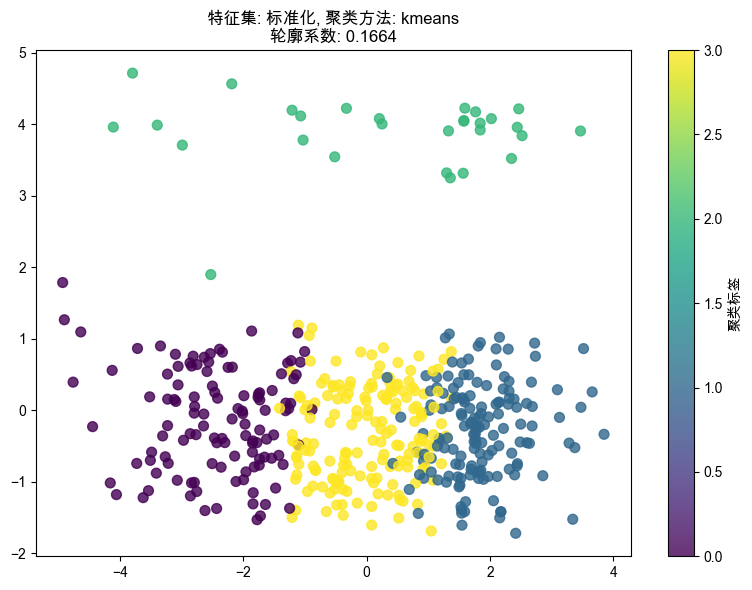

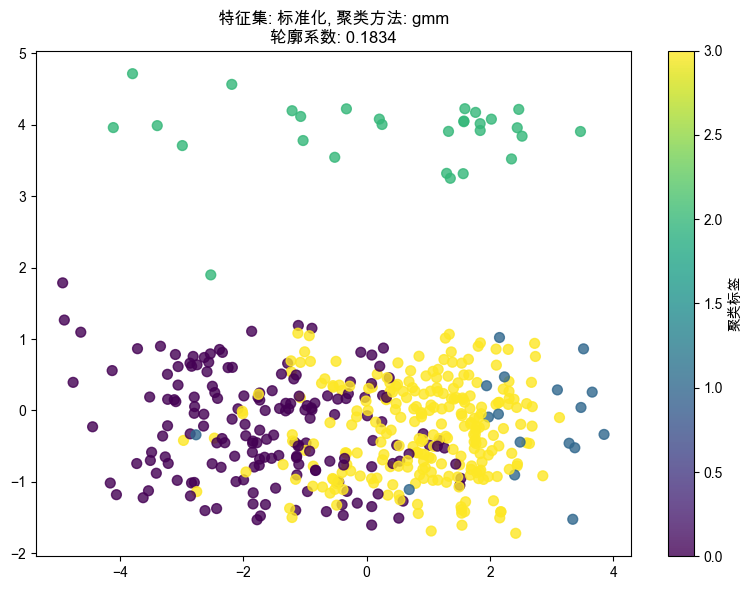

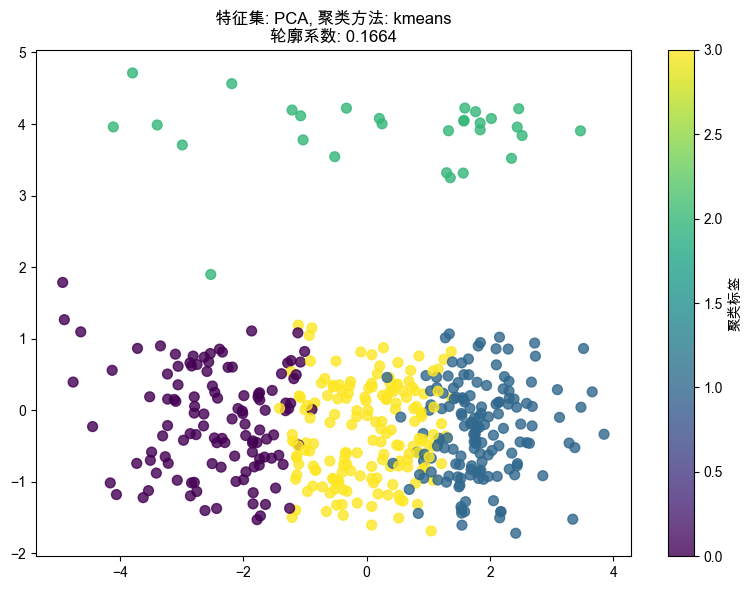

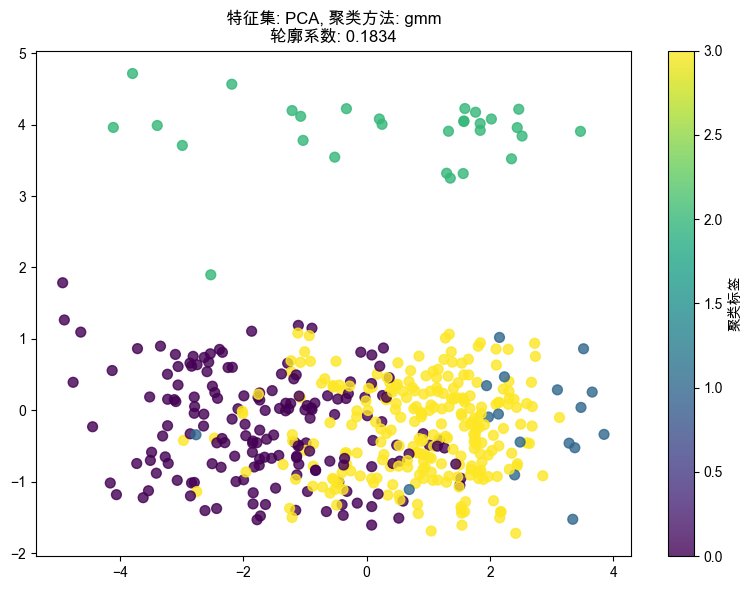

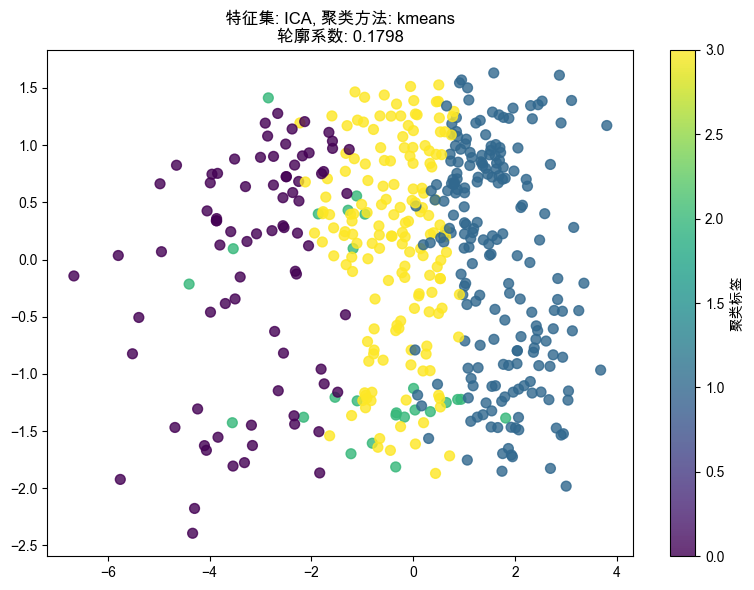

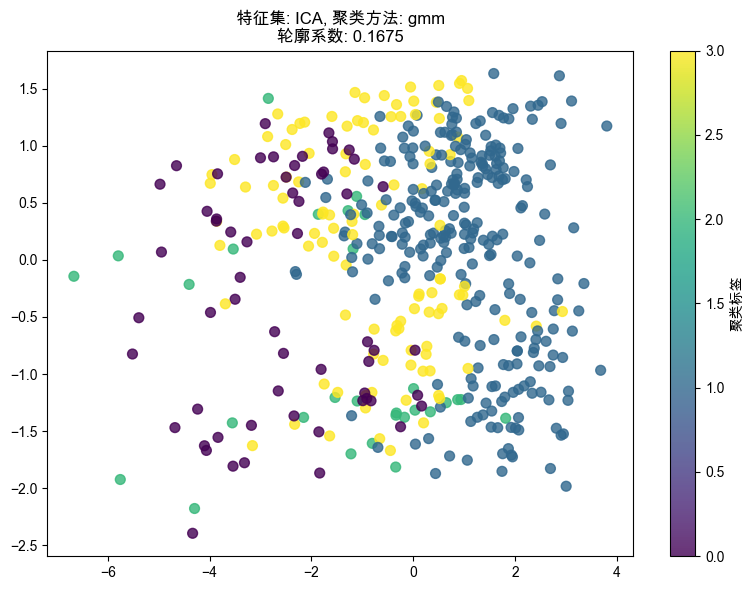

In [157]:
# 第十一个代码单元格 - 可视化最佳结果
# 8. 可视化每种特征集和聚类方法的最佳结果
for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        # 如果特征维度大于2，使用PCA降至2维进行可视化
        if feature_sets[feature_name].shape[1] > 2:
            vis_pca = PCA(n_components=2)
            X_vis = vis_pca.fit_transform(feature_sets[feature_name])
        else:
            X_vis = feature_sets[feature_name]

        plt.figure(figsize=(8, 6))
        plt.scatter(X_vis[:, 0], X_vis[:, 1], c=result['labels'], cmap='viridis', alpha=0.8, s=50)
        plt.title(f'特征集: {feature_name}, 聚类方法: {method_name}\n轮廓系数: {result["silhouette_score"]:.4f}')
        plt.colorbar(label='聚类标签')
        plt.tight_layout()
        plt.show()

最佳聚类结果汇总表:


,特征集,聚类方法,轮廓系数,Davies-Bouldin,Calinski-Harabasz,聚类数,初始化方法,聚类数/组件数,协方差类型
0,ICA,gmm,0.167478,1.743646,81.773498,NaN,None,4.0,tied
1,ICA,kmeans,0.179774,1.661897,111.598210,4.0,k-means++,NaN,None
2,PCA,gmm,0.183388,1.509892,83.419252,NaN,None,4.0,tied
3,PCA,kmeans,0.166380,1.692916,118.527225,4.0,k-means++,NaN,None
4,标准化,gmm,0.183388,1.509892,83.419252,NaN,None,4.0,tied
5,标准化,kmeans,0.166380,1.692916,118.527225,4.0,k-means++,NaN,None


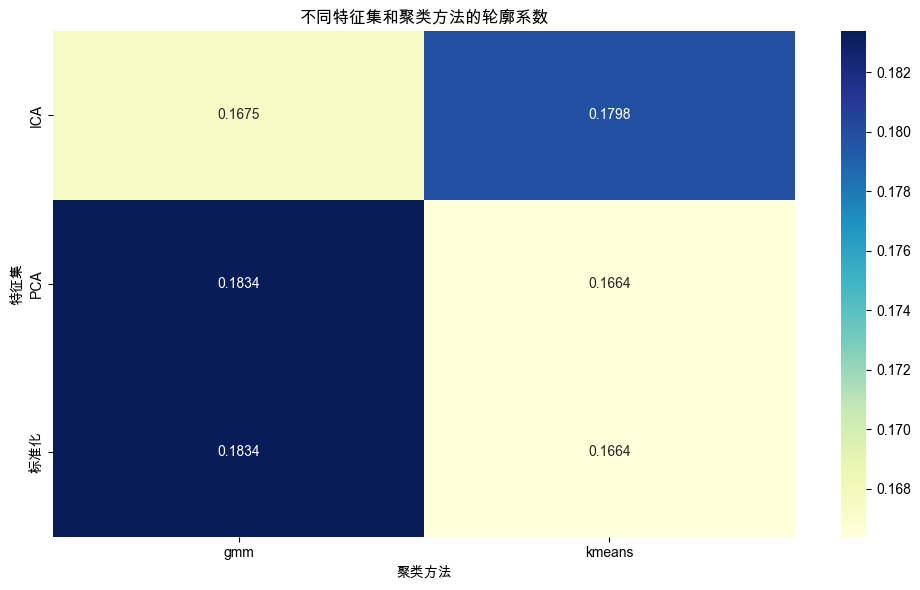

In [158]:
# 第十二个代码单元格 - 汇总表格
# 9. 生成最佳结果的汇总表格
summary_df = pd.DataFrame(results_table)

# 按特征集和聚类方法分组，找出每种组合的最佳结果
best_by_feature = summary_df.sort_values('轮廓系数', ascending=False).groupby(['特征集', '聚类方法']).first().reset_index()

print("最佳聚类结果汇总表:")
display(best_by_feature)

# 创建热力图显示不同特征集和聚类方法的轮廓系数
pivot_table = best_by_feature.pivot(index='特征集', columns='聚类方法', values='轮廓系数')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', fmt='.4f')
plt.title('不同特征集和聚类方法的轮廓系数')
plt.tight_layout()
plt.show()

数据集形状: (466, 10)
   Index  Gender  Grade  Q1  Q2  Q3    Q4  Q5 Programme  Total
0      1       1      3   8   4   2  10.0   0         C   24.0
1      2       2      3   4   2   8   8.0   0         C   22.0
2      3       2      3   4   0   0   0.0   2         A    6.0
3      4       1      3   0   2   4   0.0   0         B    6.0
4      5       2      2   8   8   6   8.0   3         A   33.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      466 non-null    int64  
 1   Gender     466 non-null    int64  
 2   Grade      466 non-null    int64  
 3   Q1         466 non-null    int64  
 4   Q2         466 non-null    int64  
 5   Q3         466 non-null    int64  
 6   Q4         466 non-null    float64
 7   Q5         466 non-null    int64  
 8   Programme  466 non-null    object 
 9   Total      466 non-null    float64
dtypes: float64(2), 

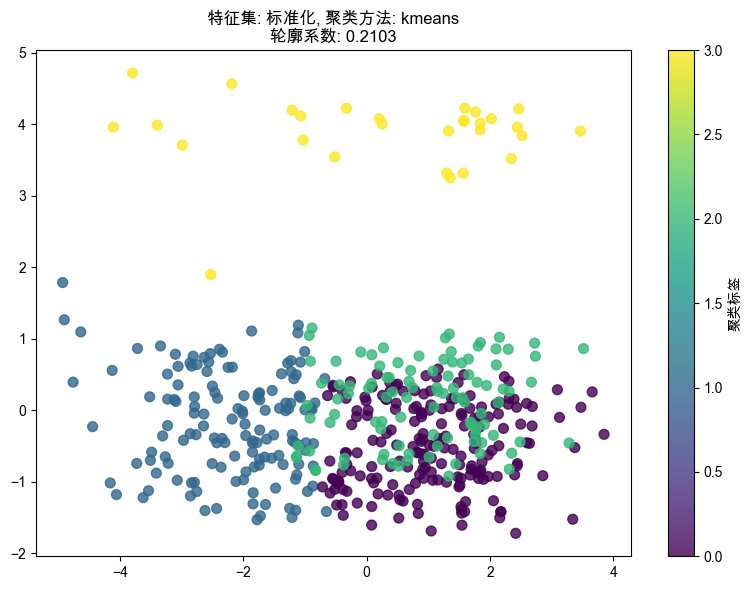

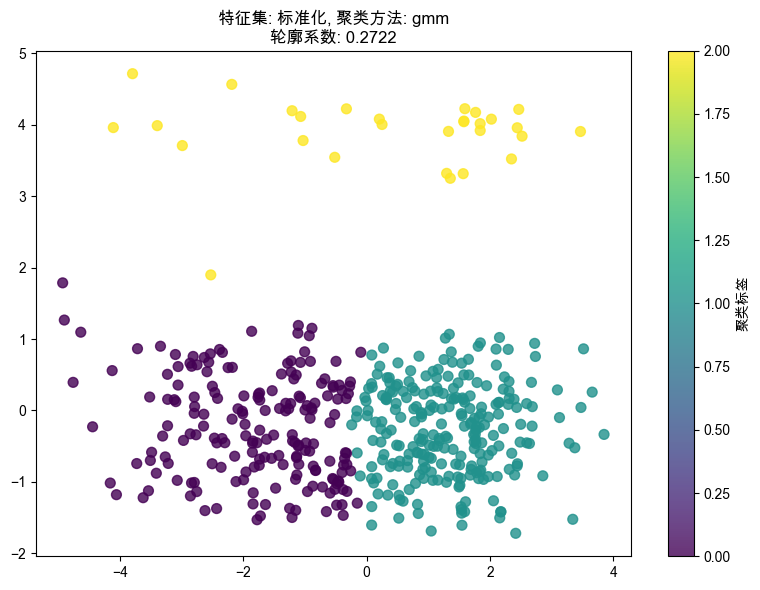

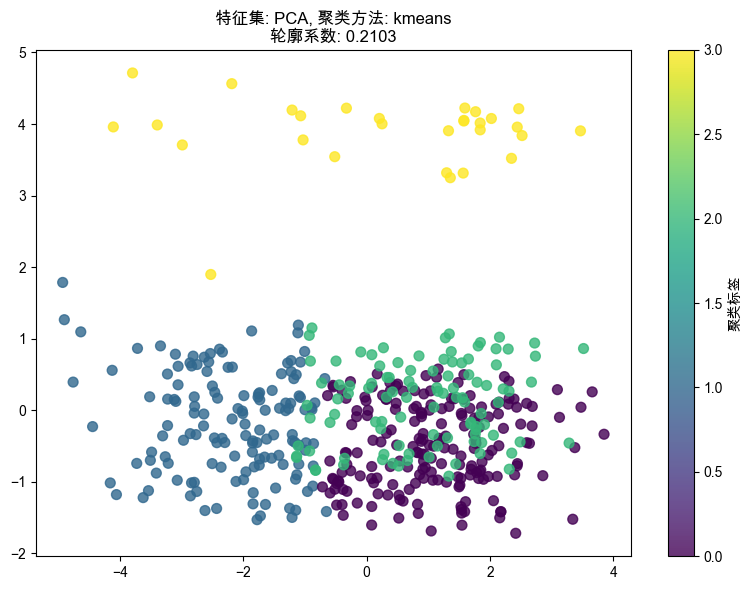

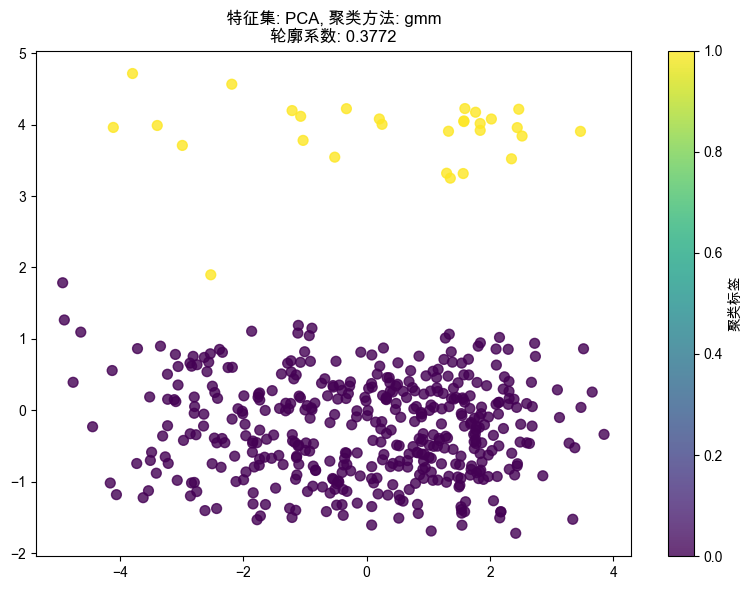

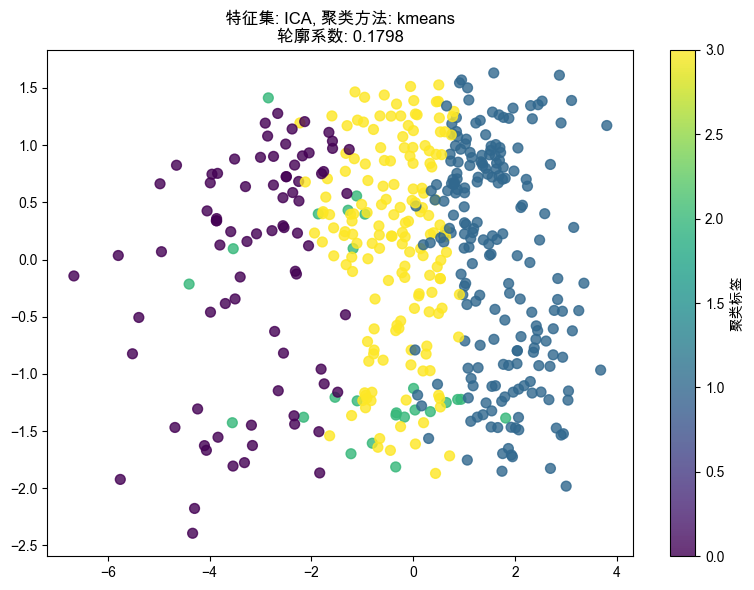

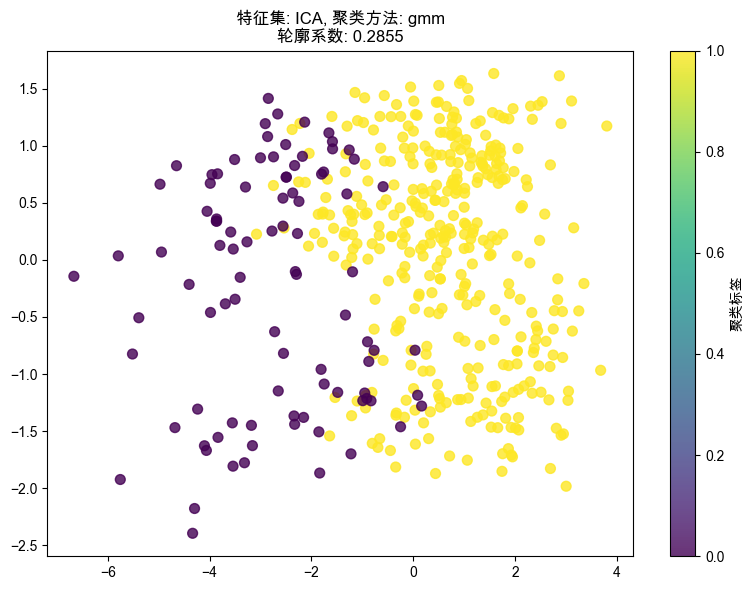

In [159]:
# 导入聚类相关的库
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
from sklearn.decomposition import FastICA, TruncatedSVD
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 检查数据集
print(f"数据集形状: {df.shape}")
print(df.head())
print(df.info())
print(df.describe())

# 检查缺失值
print(f"缺失值情况:\n{df.isnull().sum()}")

# 假设我们要处理的是数值特征，去除非数值列
# 根据实际数据集调整
X = df.select_dtypes(include=['float64', 'int64'])
print(f"特征集形状: {X.shape}")

# 1. 应用三种不同的数据转换方法
# 存储所有转换后的特征集
feature_sets = {}

# 转换1: 标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
feature_sets['标准化'] = X_scaled

# 转换2: PCA降维
pca = PCA(n_components=min(X.shape[1], 10))
X_pca = pca.fit_transform(X_scaled)
feature_sets['PCA'] = X_pca
print(f"PCA解释方差比: {pca.explained_variance_ratio_}")
print(f"PCA累计方差占比: {np.sum(pca.explained_variance_ratio_)}")

# 转换3: FastICA (独立成分分析)
ica = FastICA(n_components=min(X.shape[1], 10), random_state=42)
X_ica = ica.fit_transform(X_scaled)
feature_sets['ICA'] = X_ica

# 2. 定义评估函数
def evaluate_clustering(X, labels, name):
    """计算聚类性能指标"""
    try:
        silhouette = silhouette_score(X, labels)
    except:
        silhouette = -1

    try:
        db_score = davies_bouldin_score(X, labels)
    except:
        db_score = float('inf')

    try:
        ch_score = calinski_harabasz_score(X, labels)
    except:
        ch_score = -1

    return {
        'silhouette_score': silhouette,  # 越高越好
        'davies_bouldin_score': db_score,  # 越低越好
        'calinski_harabasz_score': ch_score,  # 越高越好
        'method': name
    }

# 3. 定义聚类方法及其参数范围
def run_kmeans(X, n_clusters_range=[4], init_methods=['k-means++', 'random']):
    """运行K-means并尝试不同参数"""
    results = []

    for n_clusters in n_clusters_range:
        for init in init_methods:
            name = f"KMeans(n_clusters={n_clusters}, init={init})"
            try:
                model = KMeans(n_clusters=n_clusters, init=init, random_state=42)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_clusters'] = n_clusters
                result['init'] = init

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

def run_gmm(X, n_components_range=[2, 3, 4, 5, 6, 7, 8], covariance_types=['full', 'tied', 'diag', 'spherical']):
    """运行高斯混合模型并尝试不同参数"""
    results = []

    for n_components in n_components_range:
        for cov_type in covariance_types:
            name = f"GMM(n_components={n_components}, covariance_type={cov_type})"
            try:
                model = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=42)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_components'] = n_components
                result['covariance_type'] = cov_type

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

def run_hierarchical(X, n_clusters_range=[4], linkage_methods=['ward', 'complete', 'average', 'single']):
    """运行层次聚类并尝试不同参数"""
    results = []

    for n_clusters in n_clusters_range:
        for linkage in linkage_methods:
            # ward只能用于欧氏距离
            if linkage == 'ward':
                affinity = 'euclidean'
            else:
                affinity = 'euclidean'  # 也可以尝试其他距离

            name = f"HC(n_clusters={n_clusters}, linkage={linkage})"
            try:
                model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage, affinity=affinity)
                labels = model.fit_predict(X)

                # 评估结果
                result = evaluate_clustering(X, labels, name)
                result['labels'] = labels
                result['model'] = model
                result['n_clusters'] = n_clusters
                result['linkage'] = linkage

                results.append(result)
                print(f"完成: {name}")
            except Exception as e:
                print(f"错误 {name}: {str(e)}")

    return results

# 4. 运行所有实验并收集结果
all_results = {}

for feature_name, X_transformed in feature_sets.items():
    print(f"\n处理特征集: {feature_name}")

    # 运行三种聚类算法
    kmeans_results = run_kmeans(X_transformed)
    gmm_results = run_gmm(X_transformed)
    hc_results = run_hierarchical(X_transformed)

    # 保存结果
    all_results[feature_name] = {
        'kmeans': kmeans_results,
        'gmm': gmm_results,
        'hierarchical': hc_results
    }

# 5. 找出每种特征集和每种聚类方法的最佳结果
best_results = {}

for feature_name, methods in all_results.items():
    best_results[feature_name] = {}

    for method_name, results in methods.items():
        if method_name in ['kmeans', 'gmm', 'hierarchical']:
            # 按silhouette_score排序（越高越好）
            sorted_results = sorted(results, key=lambda x: x['silhouette_score'], reverse=True)
            if sorted_results:
                best_results[feature_name][method_name] = sorted_results[0]

# 6. 创建结果表格
results_table = []

for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        row = {
            '特征集': feature_name,
            '聚类方法': method_name,
            '轮廓系数': result['silhouette_score'],
            'Davies-Bouldin': result['davies_bouldin_score'],
            'Calinski-Harabasz': result['calinski_harabasz_score']
        }

        # 添加模型特有的参数
        if method_name == 'kmeans':
            row['聚类数'] = result['n_clusters']
            row['初始化方法'] = result['init']
        elif method_name == 'gmm':
            row['组件数'] = result['n_components']
            row['协方差类型'] = result['covariance_type']
        elif method_name == 'hierarchical':
            row['聚类数'] = result['n_clusters']
            row['链接方法'] = result['linkage']

        results_table.append(row)

# 7. 将结果转换为DataFrame并显示
results_df = pd.DataFrame(results_table)
print("\n聚类结果表:")
print(results_df)

# 8. 可视化每种特征集和聚类方法的最佳结果
for feature_name, methods in best_results.items():
    for method_name, result in methods.items():
        # 如果特征维度大于2，使用PCA降至2维进行可视化
        if feature_sets[feature_name].shape[1] > 2:
            vis_pca = PCA(n_components=2)
            X_vis = vis_pca.fit_transform(feature_sets[feature_name])
        else:
            X_vis = feature_sets[feature_name]

        plt.figure(figsize=(8, 6))
        plt.scatter(X_vis[:, 0], X_vis[:, 1], c=result['labels'], cmap='viridis', alpha=0.8, s=50)
        plt.title(f'特征集: {feature_name}, 聚类方法: {method_name}\n轮廓系数: {result["silhouette_score"]:.4f}')
        plt.colorbar(label='聚类标签')
        plt.tight_layout()
        plt.show()

# 9. 保存最佳模型及其结果
# 此处可以添加模型持久化代码，如使用pickle保存模型